In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler
import os

In [4]:
old_df = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction-data/train.csv')
old_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
new_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
new_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [6]:
old_df['Response'].value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

In [7]:
new_df['Response'].value_counts()

Response
0    10089739
1     1415059
Name: count, dtype: int64

In [8]:
old_df_1 = old_df[old_df['Response'] == 1]
df = pd.concat([new_df, old_df_1], ignore_index=True)

In [9]:
df['Response'].value_counts()

Response
0    10089739
1     1461769
Name: count, dtype: int64

In [10]:
df.drop(columns=['id'], inplace=True)

In [11]:
print("before drop duplicates : ", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("after drop duplicates : ", df.duplicated().sum())

before drop duplicates :  25
after drop duplicates :  0


In [12]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,21,1,35.0,0,65101.0,124.0,187,0,True,False,False,True
1,43,1,28.0,0,58911.0,26.0,288,1,True,False,True,True
2,25,1,14.0,1,38043.0,152.0,254,0,False,True,False,False
3,35,1,1.0,0,2630.0,156.0,76,0,False,False,False,True
4,36,1,15.0,1,31951.0,152.0,294,0,False,False,False,False


In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Define the pipeline
over = SMOTE(sampling_strategy=0.5)  # Adjust the ratio as needed
under = RandomUnderSampler(sampling_strategy=0.5)  # Adjust the ratio as needed
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
x = df_encoded.drop(columns=['Response'])
y = df_encoded['Response']
df_encoded, target = pipeline.fit_resample(x, y)

In [14]:
target.value_counts()

Response
0    10089738
1     5044869
Name: count, dtype: int64

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
scaler = MinMaxScaler()
numerical_features = ['Age', 'Annual_Premium', 'Vintage', 'Region_Code', 'Policy_Sales_Channel']
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])
df_encoded.head()


,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
4074654,0.015385,1,0.865385,1,0.042470,0.932099,0.512111,False,True,False,False
2583194,0.738462,1,0.788462,0,0.066152,0.154321,0.394464,True,False,True,True
7015926,0.061538,1,0.903846,0,0.078423,0.932099,0.564014,True,True,False,True
9875076,0.800000,1,0.134615,1,0.000000,0.154321,0.678201,True,False,False,False
7864362,0.476923,1,0.538462,0,0.066504,0.759259,0.799308,False,False,False,True


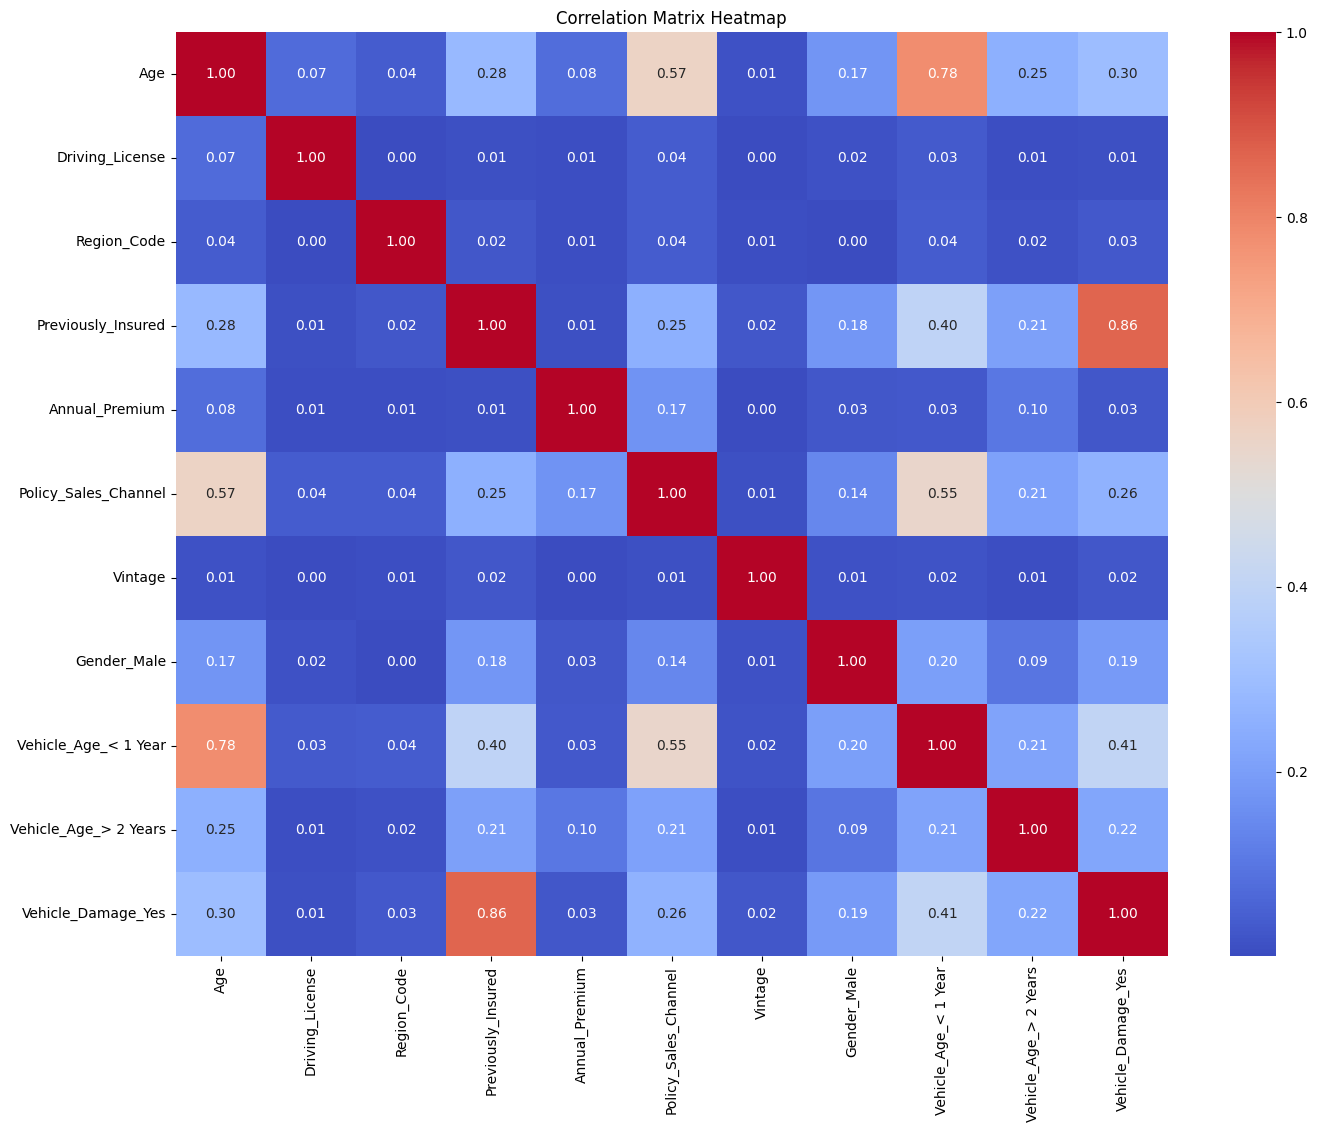

In [16]:
corr_matrix = df_encoded.corr().abs()
corr_matrix.head()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [17]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

In [18]:
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)

[]


In [19]:
df_final = df_encoded.drop(columns=to_drop)

In [20]:
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def train_and_evaluate_model(data, target, model, cv=5):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
    
    # Perform cross-validation
    cv = StratifiedKFold(n_splits=cv)
    y_pred_prob_cv = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    
    # Calculate the ROC curve and AUC score for cross-validation
    fpr_cv, tpr_cv, _ = roc_curve(y_train, y_pred_prob_cv)
    auc_score_cv = roc_auc_score(y_train, y_pred_prob_cv)
    
    # Train the model on the entire training set
    model.fit(X_train, y_train)
    
    # Predict probabilities for the test set
    y_pred_prob_test = model.predict_proba(X_test)[:, 1]
    
    # Calculate the ROC curve and AUC score for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
    auc_score_test = roc_auc_score(y_test, y_pred_prob_test)
    
    # Plot the ROC curve for both cross-validation and test set
    plt.figure()
    plt.plot(fpr_cv, tpr_cv, color='blue', lw=2, label=f'CV ROC curve (area = {auc_score_cv:.2f})')
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (area = {auc_score_test:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return model

In [21]:
data = df_final

In [22]:
data.rename(columns={'Vehicle_Age_< 1 Year':'Vehicle_Age_less_1_Year', 'Vehicle_Age_> 2 Years':'Vehicle_Age_greater_2_Years'}, inplace=True)

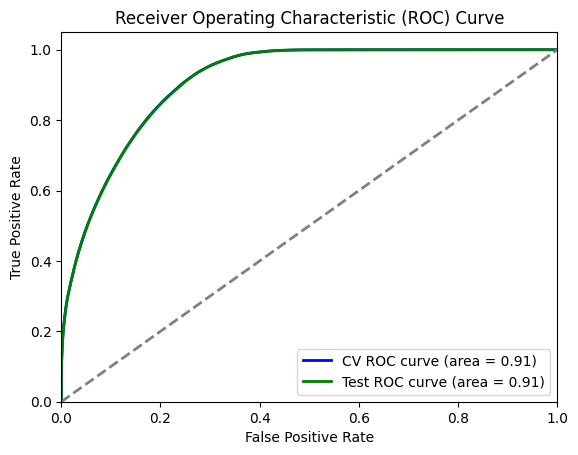

In [23]:
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)
catboost_model = train_and_evaluate_model(data, target, catboost_model)

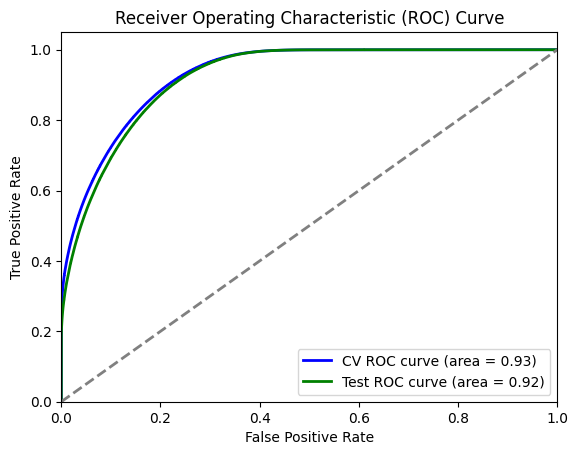

In [25]:
from xgboost import XGBClassifier
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgboost_model = train_and_evaluate_model(data, target, xgboost_model)

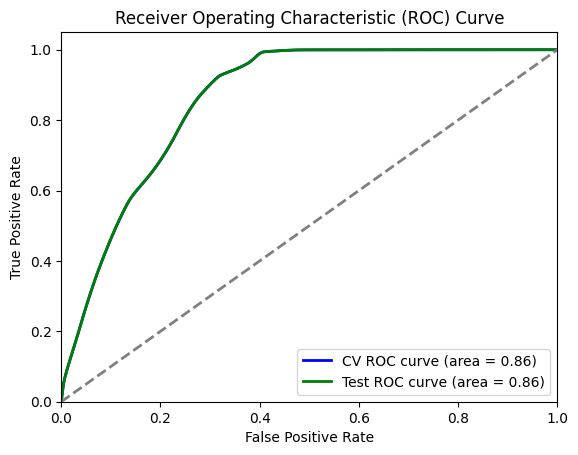

In [26]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(solver='liblinear', random_state=42)
logistic_regression_model = train_and_evaluate_model(data, target, logistic_regression_model)

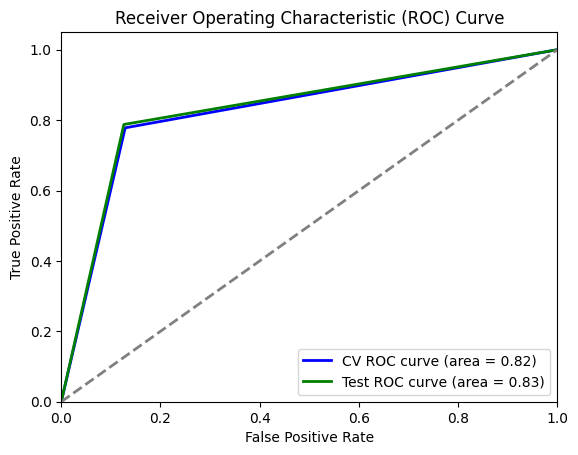

In [27]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model = train_and_evaluate_model(data, target, decision_tree_model)

[LightGBM] [Info] Number of positive: 3227598, number of negative: 6458550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.394170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 9686148, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333218 -> initscore=-0.693667
[LightGBM] [Info] Start training from score -0.693667
[LightGBM] [Info] Number of positive: 3227598, number of negative: 6458550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.395707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 9686148, number of used features: 11
[Light

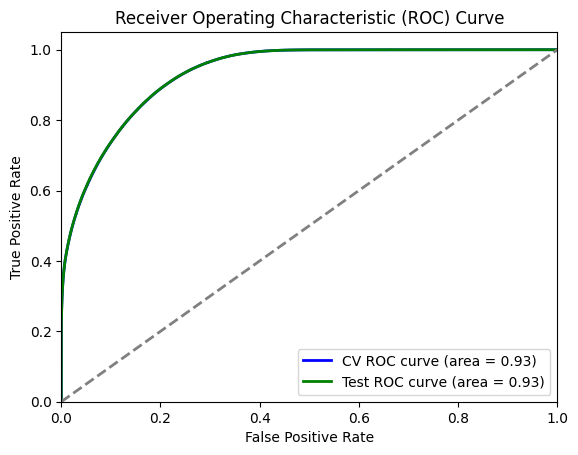

In [28]:
import lightgbm as lgb
lightgbm_model = lgb.LGBMClassifier(random_state=42)
lightgbm_model = train_and_evaluate_model(data, target, lightgbm_model)

In [29]:
def test_dataset(filename):
    test_df = pd.read_csv(filename)
    test_df.drop(columns=['id'], inplace=True)
    test_df_encoded = pd.get_dummies(test_df, drop_first=True)
    numerical_features = ['Age', 'Policy_Sales_Channel']
    test_df_encoded[numerical_features] = scaler.fit_transform(test_df_encoded[numerical_features])
    test_df_encoded.rename(columns={'Vehicle_Age_< 1 Year':'Vehicle_Age_less_1_Year', 'Vehicle_Age_> 2 Years':'Vehicle_Age_greater_2_Years'}, inplace=True)
    return test_df_encoded

In [30]:
test_data = test_dataset('/kaggle/input/playground-series-s4e7/test.csv')
predictions_1 = catboost_model.predict(test_data)

In [31]:
predictions_2 = xgboost_model.predict(test_data)

In [32]:
predictions_3 = logistic_regression_model.predict(test_data)

In [33]:
predictions_4 = decision_tree_model.predict(test_data)

In [34]:
predictions_5 = lightgbm_model.predict(test_data)

In [35]:
print(predictions_1)
print(predictions_2)
print(predictions_3)
print(predictions_4)
print(predictions_5)

[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]


In [40]:
from scipy import stats
predictions = stats.mode([predictions_1, predictions_2, predictions_4, predictions_5], axis=0)
print(predictions)

ModeResult(mode=array([0, 0, 0, ..., 0, 0, 0]), count=array([4, 4, 4, ..., 4, 2, 4]))


In [28]:
len(predictions)

7669866

In [41]:
id = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')['id']
result = pd.DataFrame()
result['id'] = id
result['Response'] = predictions.mode
result.to_csv('result_5.csv', index=False)